This file is meant for *development* of hyperparameter optimization. Final metrics for hyperparameter optimization can be found at *total_results.ipynb*.

In [15]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1022 (delta 106), reused 76 (delta 49), pack-reused 860 (from 2)
Receiving objects: 100% (1022/1022), 39.84 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (590/590), done.
Filtering content: 100% (33/33), 1.75 GiB | 33.43 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [16]:
!pip install ta # remove after updated kalman worfklow
!pip install pykalman
!pip install PyWavelets # remove after updated kalman worfklow
!pip install curl-cffi # remove after updated kalman worfklow
!pip install scikit-optimize

In [17]:
!pip install scikit-optimize

In [18]:
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple

# extra
import time

In [47]:
def bayesian_optimize_workflow(
    execute_workflow_fn: Callable,
    top_pair_count: int,
    start_year: int,
    min_end_year: int,
    max_end_year: int,
    search_space: List[Real],
    n_calls:int,
    seed: int,
    verbose: bool
) -> Tuple[
    Dict[str, Any], # best_params
    float # best_mean_mse
]:
    global res
    param_names = [dim.name for dim in search_space]
    instrumentIds = load_cached_etf_tickers()

    @use_named_args(search_space)
    def objective(**params):
      total_mse_list = []

      # time series cross validation: go over all periods
      for rolling_end_year in range(min_end_year, max_end_year + 1): # +1 such that end year is actually included!
        startDateStr = f"{start_year}-01-01"
        endDateStr = f"{rolling_end_year}-12-31"
        startDateStrTest = f"{rolling_end_year}-01-01"
        endDateStrTest = endDateStr

        train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

        # when new startDateStr and endDateStr are created, we also need new pairs_data_filtered and data_..._filtered_2
        data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIds, cache_dir='../src/data/cache')
        data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

        pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIds, cache_dir='../src/data/cache')
        if pairs_data_filtered is None:
          scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
          pairs_data = {key:value[1]  for (key, value) in pairs.items()}
          pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
          pairs_data_filtered = filter_pairs_data(pairs_data)
          # if it can not be retreived from cache, make sure it is saved for later
          save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIds, cache_dir='../src/data/cache')

        # for more balanced results: use top x pairs, chosen to be 5 due to stay in within realistic time and resources
        for pair_idx in range(top_pair_count):
          ticker_a, ticker_b = pairs_data_filtered[pair_idx][0][0], pairs_data_filtered[pair_idx][0][1]
          pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
          # Note: approximate time for each workflow:
          # kalman; 2-4 sec
          # transformer; ? sec
          # time-moe: ? sec
          output = execute_workflow_fn(
              pairs_timeseries_df,
              **params,
              verbose=False
          )
          total_mse_list.append(output['test_mse'])
      # get mean_mse across time periods and pairs for the current choice of hyperparameters
      print(f"total_mse_list: {total_mse_list}")
      print(f"mean mse: {np.mean(total_mse_list)}")
      mean_mse = np.mean(total_mse_list)
      return mean_mse

    # gather results
    res = gp_minimize(
        func=objective,
        dimensions=search_space,
        n_calls=n_calls,
        n_random_starts=10,
        random_state=seed,
        verbose=verbose
    )
    return res

search_space = [ # 'name' is used directly as a kwarg
    Real(1e-5, 0.1, name='delta', prior='log-uniform'),
    Real(0.5, 4, name='obs_cov_reg', prior='log-uniform'),
    Real(0.001, 0.1, name='trans_cov_avg', prior='log-uniform'),
    Real(0.1, 10, name='obs_cov_avg', prior='log-uniform')
]
SEED = 3178749

# call func
res = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=10,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2016,
    search_space=search_space,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space]
best_params = {k: res.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res.fun

Iteration No: 1 started. Evaluating function at random point.
total_mse_list: [np.float64(0.19570376329591044), np.float64(61.17236151399972), np.float64(1.692559687461877), np.float64(2562.0032265760237), np.float64(0.16187068123003462), np.float64(6192.274270397055), np.float64(1488.9296905011774), np.float64(4238.392791533013), np.float64(0.09130632252754417), np.float64(0.2046213221353704)]
mean mse: 1454.511840229792
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.8002
Function value obtained: 1454.5118
Current minimum: 1454.5118
Iteration No: 2 started. Evaluating function at random point.
total_mse_list: [np.float64(0.18975690504142326), np.float64(65.52900491858281), np.float64(1.8176724169467968), np.float64(2895.037195113894), np.float64(0.16249344824777034), np.float64(6514.464635461254), np.float64(1719.9962365365352), np.float64(4550.745433990899), np.float64(0.09234632024975509), np.float64(0.2266626359771704)]
mean mse: 1574.8261437747628
Iteration

In [44]:
best_params, best_mean_mse

({'delta': 0.1,
  'obs_cov_reg': 0.5,
  'trans_cov_avg': 0.001,
  'obs_cov_avg': 0.1},
 np.float64(0.1564579693162573))

<Axes: >

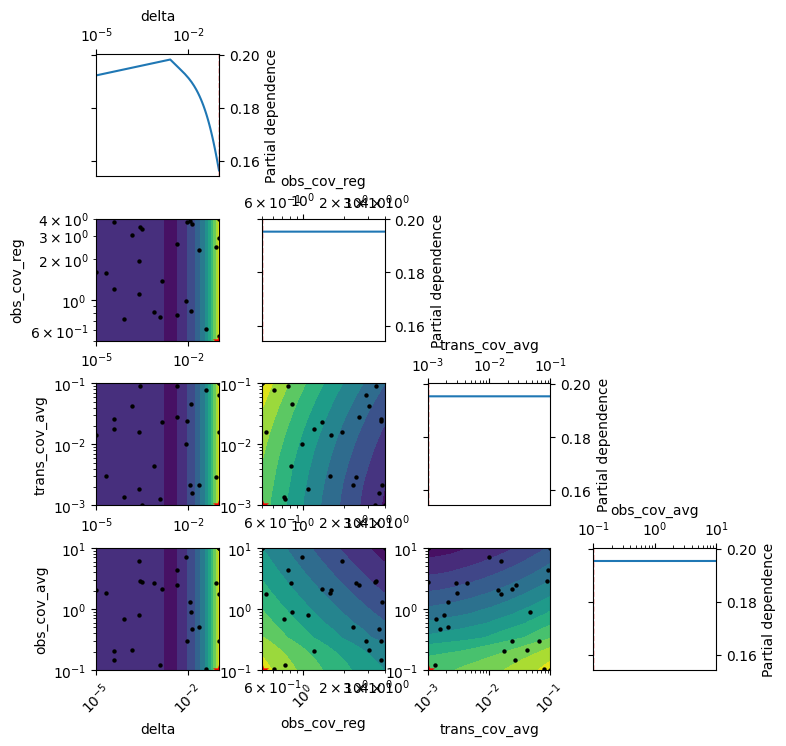

In [43]:
# plotting
from skopt import plots as skplots
# show how dimensions relate to objective evaluation
skplots.plot_objective(res)

In [ ]:

# show how often that value was used
# skplots.plot_histogram(res, dimension_identifier=2)

# show how dimensions relate to each other (amount of calls)
# skplots.plot_evaluations(res)

# show process of how dimension changed
# skplots.plot_gaussian_process(res)

# show trace of what would have been the optimal decision in hindsight
# skplots.plot_regret(res)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9710
Function value obtained: 0.1957
Current minimum: 0.1957
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3629
Function value obtained: 0.1898
Current minimum: 0.1898
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.8324
Function value obtained: 0.1902
Current minimum: 0.1898
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.9068
Function value obtained: 0.2039
Current minimum: 0.1898
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.7349
Function value obtained: 0.1631
Current minimum: 0.1631
Iteration No: 6 started. Evaluating

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

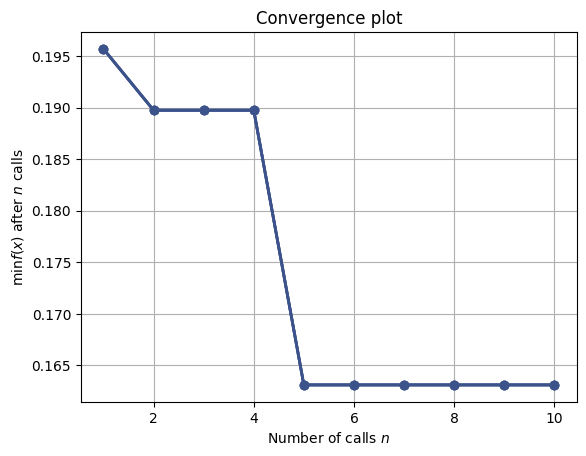

In [45]:
# SUPPLEMENTARY ANALYSIS: does it make a difference for convergence to use 1, 3 or 10 pairs?
res_1 = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2016,
    search_space=search_space,
    n_calls=10,
    seed=SEED,
    verbose=True
)
skplots.plot_convergence(res_1)

res_3 = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=3,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2016,
    search_space=search_space,
    n_calls=10,
    seed=SEED,
    verbose=True
)
skplots.plot_convergence(res_3)

res_10 = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=10,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2016,
    search_space=search_space,
    n_calls=10,
    seed=SEED,
    verbose=True
)
skplots.plot_convergence(res_10)

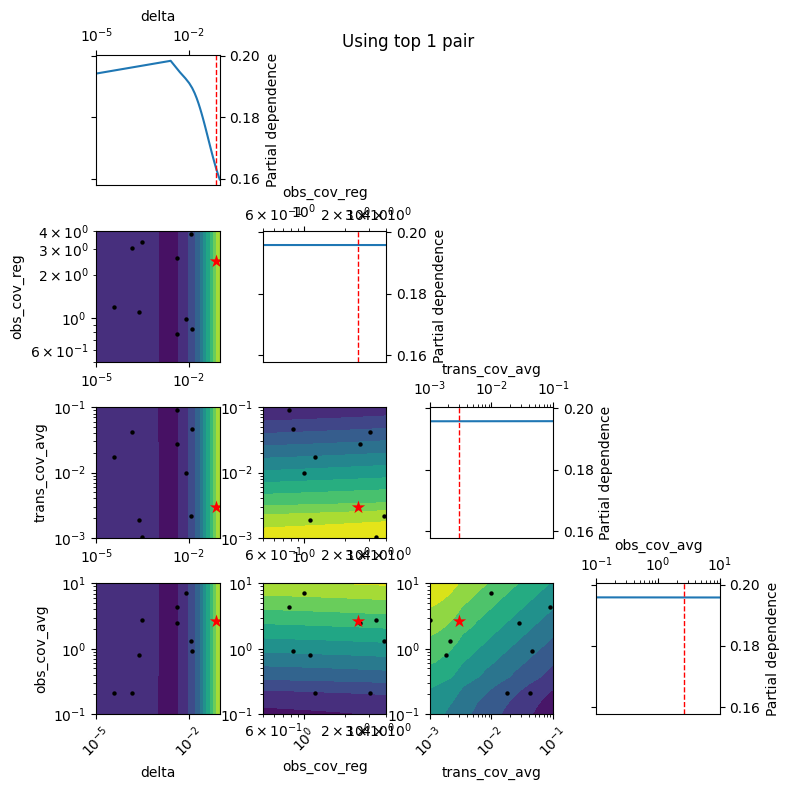

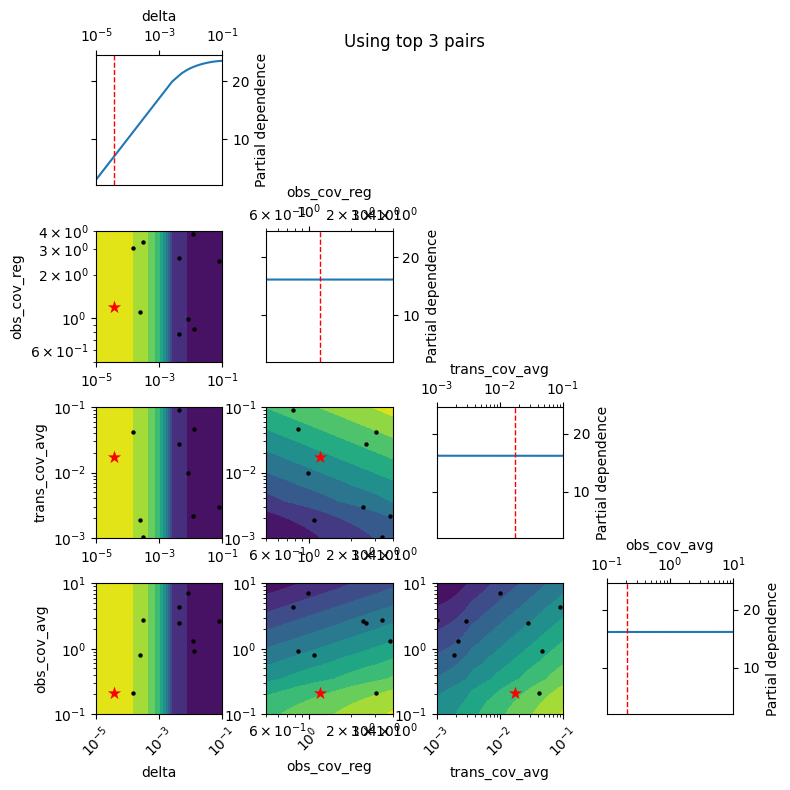

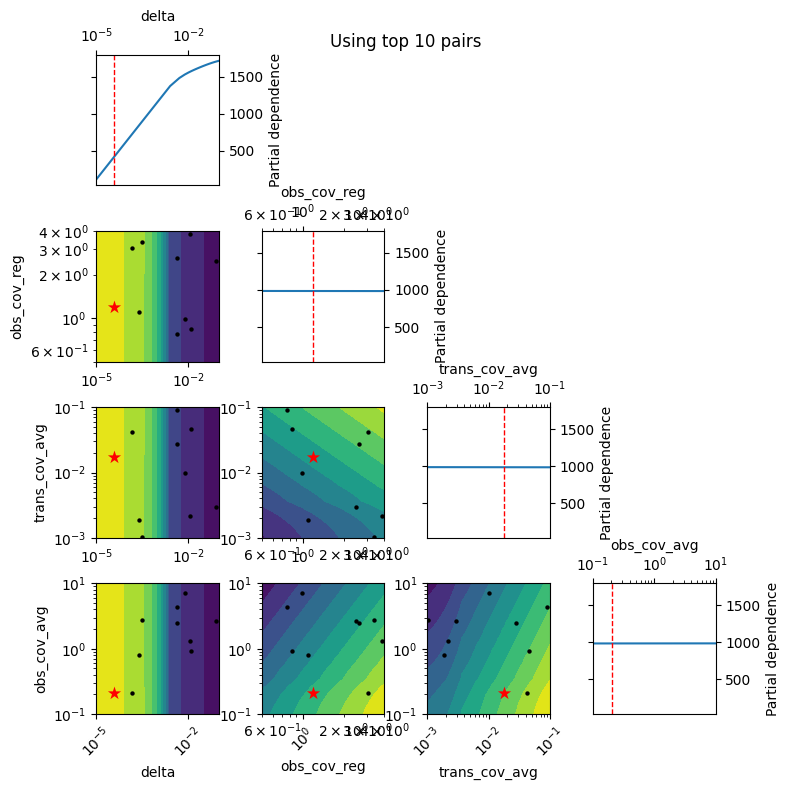

In [55]:
ax = skplots.plot_objective(res_1)
ax.set_title("Using top 1 pair")
plt.tight_layout()
plt.show()

ax = skplots.plot_objective(res_3)
ax.set_title("Using top 3 pairs")
plt.tight_layout()
plt.show()

ax = skplots.plot_objective(res_10)
ax.set_title("Using top 10 pairs")
plt.tight_layout()
plt.show()
# Conclusion: top 3 is a big enough sample in this case, but top 1 can give a totally different result

In [48]:
param_names = [dim.name for dim in search_space]
best_params = {k: res_1.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_1.fun
print(best_mean_mse, best_params)

param_names = [dim.name for dim in search_space]
best_params = {k: res_3.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_3.fun
print(best_mean_mse, best_params)

param_names = [dim.name for dim in search_space]
best_params = {k: res_10.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_10.fun
print(best_mean_mse, best_params)

0.16310183370636952 {'delta': 0.07798594693161134, 'obs_cov_reg': 2.4656432641645565, 'trans_cov_avg': 0.0029337666588654158, 'obs_cov_avg': 2.6211956124020612}
5.249387886433198 {'delta': 3.670169346708717e-05, 'obs_cov_reg': 1.1998896628761924, 'trans_cov_avg': 0.017587829770028898, 'obs_cov_avg': 0.20831440978754548}
236.053489742563 {'delta': 3.670169346708717e-05, 'obs_cov_reg': 1.1998896628761924, 'trans_cov_avg': 0.017587829770028898, 'obs_cov_avg': 0.20831440978754548}
